In [617]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
import matplotlib.gridspec as gridspec


from BSE import market_session

import matplotlib.pyplot as plt

# Set global font sizes
plt.rcParams['font.size'] = 18  # Default font size for all text
plt.rcParams['axes.titlesize'] = 18  # Font size for plot titles
plt.rcParams['axes.labelsize'] = 18  # Font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 18  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 18  # Font size for y tick labels
plt.rcParams['legend.fontsize'] = 18  # Font size for legend
plt.rcParams['figure.titlesize'] = 18  # Font size for figure titles


In [618]:
# Setting file path locations 
id = 'new_trader_chart_0_'
#id = 'heston_model_session_0_'
file_path = id + 'LOB_frames.csv'
prices = id + "tape.csv"
volumes = id + 'blotters.csv'
balances = id + 'avg_balance.csv'


In [619]:
# Initialize lists
time_list, bid_total_quantity, bid_prices, bid_quantities = [], [], [], []
ask_total_quantity, ask_prices, ask_quantities = [], [], []

# Read the file and parse the data
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        
        # Split the line using "Bid:" and "Ask:" as delimiters
        parts = re.split(r'(Bid:|Ask:)', line)
        time_stamp = float(parts[0].strip().rstrip(','))
        
        # Parse bid and ask data
        bid_data, ask_data = [], []
        for i in range(1, len(parts) - 1, 2):
            values = [int(val) for val in parts[i + 1].strip().split(',') if val.strip().isdigit()]
            if parts[i] == 'Bid:':
                bid_data = values
            elif parts[i] == 'Ask:':
                ask_data = values
        
        # Extract and assign bid data
        if bid_data:
            bid_total_quantity.append(bid_data[0])
            bid_prices.append(bid_data[1::2])  # Take prices at odd indices
            bid_quantities.append(bid_data[2::2])  # Take quantities at even indices
        else:
            bid_total_quantity.append(None)
            bid_prices.append([])
            bid_quantities.append([])
        
        # Extract and assign ask data
        if ask_data:
            ask_total_quantity.append(ask_data[0])
            ask_prices.append(ask_data[1::2])  # Take prices at odd indices
            ask_quantities.append(ask_data[2::2])  # Take quantities at even indices
        else:
            ask_total_quantity.append(None)
            ask_prices.append([])
            ask_quantities.append([])

        # Store the timestamp
        time_list.append(time_stamp)

# Create the expanded DataFrame
expanded_df = pd.DataFrame({
    'Time': time_list,
    'Bid Total Quantity': bid_total_quantity,
    'Bid Prices': [', '.join(map(str, prices)) for prices in bid_prices],
    'Bid Quantities': [', '.join(map(str, quantities)) for quantities in bid_quantities],
    'Ask Total Quantity': ask_total_quantity,
    'Ask Prices': [', '.join(map(str, prices)) for prices in ask_prices],
    'Ask Quantities': [', '.join(map(str, quantities)) for quantities in ask_quantities]
})

# Display the expanded DataFrame
expanded_df.head(5)


Time  Bid Total Quantity       Bid Prices Bid Quantities  \
0  0.000                   0                                   
1  0.112                   1                5              1   
2  0.149                   2           5, 137           1, 1   
3  0.261                   3      5, 137, 138        1, 1, 1   
4  0.299                   4  5, 42, 137, 138     1, 1, 1, 1   

   Ask Total Quantity Ask Prices Ask Quantities  
0                   0                            
1                   0                            
2                   0                            
3                   0                            
4                   0

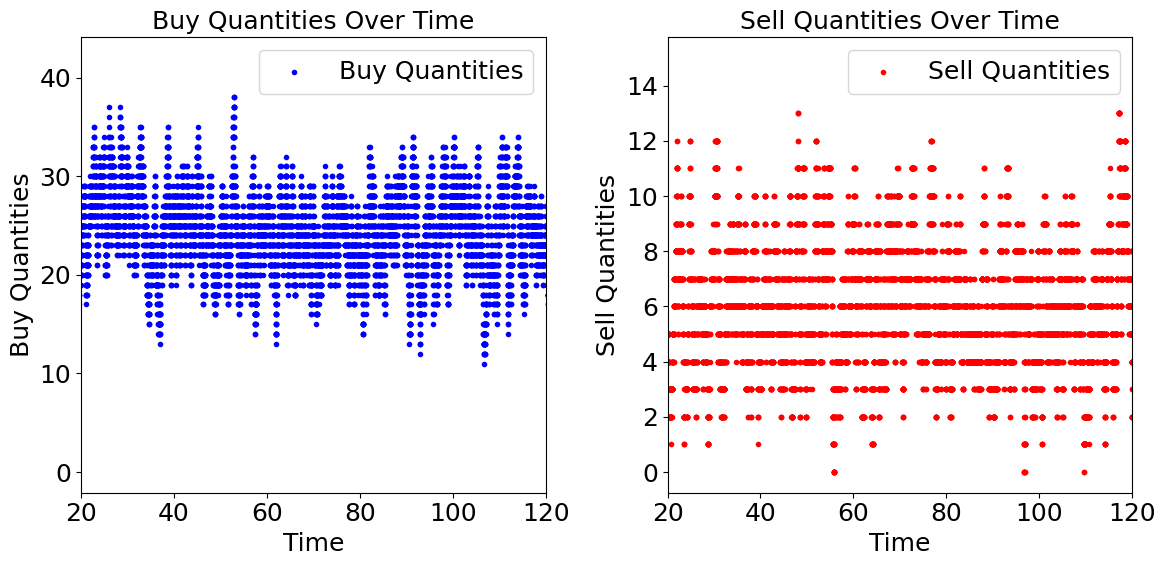

In [620]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot buy quantities
axs[0].scatter(time_list, bid_total_quantity, label='Buy Quantities', color='blue', marker = '.')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Buy Quantities')
axs[0].set_title('Buy Quantities Over Time')
axs[0].legend()
#axs[0].grid(True)

# Plot sell quantities
axs[1].scatter(time_list, ask_total_quantity, label='Sell Quantities', color='red', marker = '.')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Sell Quantities')
axs[1].set_title('Sell Quantities Over Time')
axs[1].legend()
#axs[1].grid(True)

# Show the plots
axs[0].set_xlim(20,120)
axs[1].set_xlim(20,120)
#axs[0].set_ylim(50,120)
#axs[1].set_ylim(50,120)
plt.tight_layout()
plt.show()

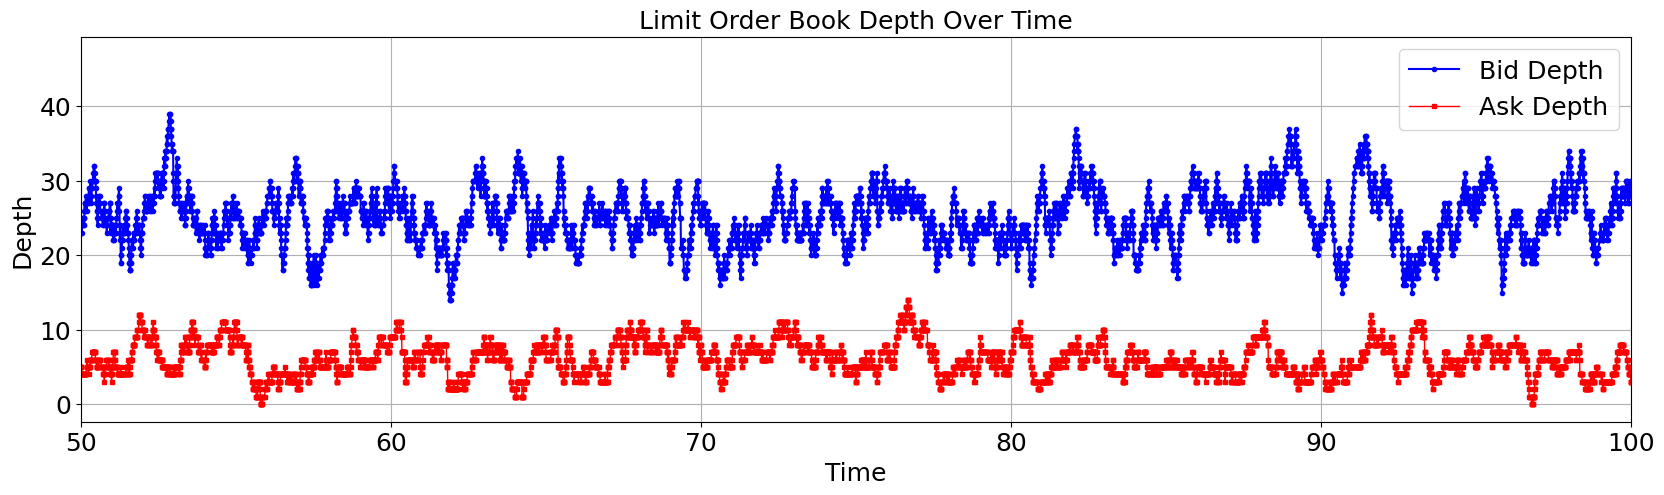

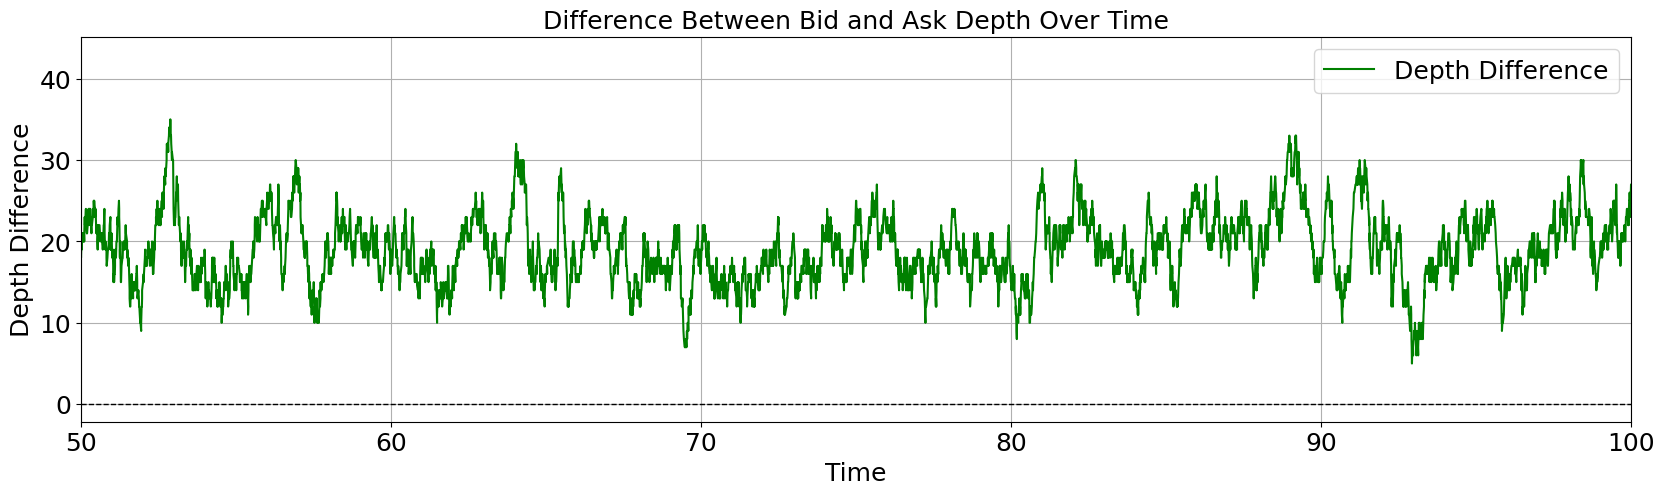

In [621]:
# Function to safely convert bid/ask quantities into lists of integers
def safe_convert_quantities(value):
    if isinstance(value, list):
        return value  # Already a list
    if isinstance(value, str):
        try:
            return [int(x) for x in value.split(',') if x.strip().isdigit()]
        except ValueError:
            return []
    return []

# Apply the safe conversion to the Bid and Ask Quantities columns
expanded_df["Bid Quantities"] = expanded_df["Bid Quantities"].apply(safe_convert_quantities)
expanded_df["Ask Quantities"] = expanded_df["Ask Quantities"].apply(safe_convert_quantities)

# Compute Bid and Ask Depth
expanded_df["Bid Depth"] = expanded_df["Bid Quantities"].apply(sum)
expanded_df["Ask Depth"] = expanded_df["Ask Quantities"].apply(sum)

# Plot the Bid and Ask Depth over Time
plt.figure(figsize=(20, 5))
plt.plot(expanded_df["Time"], expanded_df["Bid Depth"], marker=".", linestyle="-", label="Bid Depth", color = 'blue')
plt.plot(expanded_df["Time"], expanded_df["Ask Depth"], marker="s", linestyle="-", label="Ask Depth", color = 'red', markersize=3, linewidth=1)
plt.xlabel("Time")
plt.ylabel("Depth")
plt.xlim(50,100)
plt.legend()
plt.grid()
plt.title("Limit Order Book Depth Over Time")
# Calculate the difference between Bid Depth and Ask Depth
expanded_df["Depth Difference"] = expanded_df["Bid Depth"] - expanded_df["Ask Depth"]

# Plot the Depth Difference over Time
plt.figure(figsize=(20, 5))
plt.plot(expanded_df["Time"], expanded_df["Depth Difference"], marker="none", linestyle="-", label="Depth Difference", color='green')
plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Baseline at y=0
plt.xlabel("Time")
plt.ylabel("Depth Difference")
plt.title("Difference Between Bid and Ask Depth Over Time")
plt.legend()
plt.grid()

# Show plot
plt.xlim(50,100)
plt.show()
# Plot the Depth Difference over Time as a bar chart
#plt.figure(figsize=(20, 5))
#plt.bar(expanded_df["Time"], expanded_df["Depth Difference"], color='black', label="Depth Difference")
#plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Baseline at y=0
#plt.xlabel("Time")
#plt.ylabel("Depth Difference")
#plt.title("Difference Between Bid and Ask Depth Over Time")
#plt.legend()
#plt.grid()

# Show plot
#plt.xlim(50, 100)
#plt.show()


In [622]:
def parse_price_string(price_str):
    """
    Given a string like '3,4,5,6', parse and return [3, 4, 5, 6] as integers.
    If the cell is empty or None, return an empty list.
    """
    if not price_str:  # handles None or empty
        return []
    # Split on commas and convert each piece to int
    return [int(p) for p in price_str.split(',') if p.strip().isdigit()]

# Parse the Bid Prices and Ask Prices columns into lists of integers
expanded_df['ParsedBidPrices'] = expanded_df['Bid Prices'].apply(parse_price_string)
expanded_df['ParsedAskPrices'] = expanded_df['Ask Prices'].apply(parse_price_string)

# Compute the highest bid and lowest ask at each timestamp
expanded_df['HighestBid'] = expanded_df['ParsedBidPrices'].apply(lambda prices: max(prices) if prices else None)
expanded_df['LowestAsk'] = expanded_df['ParsedAskPrices'].apply(lambda prices: min(prices) if prices else None)

# Display the resulting DataFrame with the new columns
expanded_df[['Time', 'HighestBid', 'LowestAsk']].head(5)

Time  HighestBid  LowestAsk
0  0.000         NaN        NaN
1  0.112         5.0        NaN
2  0.149       137.0        NaN
3  0.261       138.0        NaN
4  0.299       138.0        NaN

In [623]:
expanded_df['MidPrice'] = 0.5 * (expanded_df['HighestBid'] + expanded_df['LowestAsk'])

In [624]:
# Initialize an empty list to store each trade as a dictionary
trades = []

# Variable to keep track of the current trader ID
current_trader = None

# Open and read the CSV file line by line
with open(volumes, 'r') as file:
    for line in file:
        parts = line.strip().split(', ')
        
        # Check if line indicates a new trader's trade count (e.g., "B00, 8")
        if len(parts) == 2 and parts[1].isdigit():
            current_trader = parts[0]  # Set the trader ID (e.g., "B00")
        
        # Check if line has enough parts to be a trade entry
        elif len(parts) >= 7:
            # Create a dictionary for each trade entry
            trade = {
                'TraderID': current_trader,
                'Type': parts[1],
                'Timestamp': float(parts[2]),
                'Price': int(parts[3]),
                'Seller': parts[4],
                'Buyer': parts[5],
                'Quantity': int(parts[6])
            }
            trades.append(trade)
        else:
            print(f"Skipping line due to unexpected format: {line}")

# Convert the list of trades to a DataFrame
blotters = pd.DataFrame(trades)

# Display the resulting DataFrame
blotters.head(5)

TraderID   Type  Timestamp  Price Seller Buyer  Quantity
0      B00  Trade      4.388    237    B00   S03         1
1      B00  Trade      6.448    255    S09   B00         1
2      B00  Trade      9.291    248    S29   B00         1
3      B00  Trade     13.172    267    B00   S30         1
4      B00  Trade     19.657    251    B00   S02         1

In [625]:
# Sort the blotters DataFrame by the Timestamp column in ascending order
blotters_sorted = blotters.sort_values(by='Timestamp').reset_index(drop=True)

# Display the sorted DataFrame
blotters_sorted.head(5)

TraderID   Type  Timestamp  Price Seller Buyer  Quantity
0      B90  Trade      0.493    190    B90   S30         1
1      S30  Trade      0.493    190    B90   S30         1
2      B70  Trade      0.672    191    S20   B70         1
3      B23  Trade      0.724    190    B23   S15         1
4      S15  Trade      0.724    190    B23   S15         1

In [626]:
expanded_df['MidPrice'] = 0.5 * (expanded_df['HighestBid'] + expanded_df['LowestAsk'])
expanded_df['BuyDepth'] = blotters['Price'] - expanded_df['HighestBid']  
expanded_df['SellDepth'] = expanded_df['LowestAsk'] - blotters['Price']

expanded_df.head(5)

Time  Bid Total Quantity       Bid Prices Bid Quantities  \
0  0.000                   0                              []   
1  0.112                   1                5            [1]   
2  0.149                   2           5, 137         [1, 1]   
3  0.261                   3      5, 137, 138      [1, 1, 1]   
4  0.299                   4  5, 42, 137, 138   [1, 1, 1, 1]   

   Ask Total Quantity Ask Prices Ask Quantities  Bid Depth  Ask Depth  \
0                   0                        []          0          0   
1                   0                        []          1          0   
2                   0                        []          2          0   
3                   0                        []          3          0   
4                   0                        []          4          0   

   Depth Difference    ParsedBidPrices ParsedAskPrices  HighestBid  LowestAsk  \
0                 0                 []              []         NaN        NaN   
1                 1                [5]              []         5.0        NaN   
2                 2           [5, 137]              []       137.0        NaN   
3                 3      [5, 137, 138]              []       138.0        NaN   
4                 4  [5, 42, 137, 138]              []       138.0        NaN   

   MidPrice  BuyDepth  SellDepth  
0       NaN       NaN        NaN  
1       NaN     250.0        NaN  
2       NaN     111.0        NaN  
3       NaN     129.0        NaN  
4       NaN     113.0        NaN

In [627]:
# Merge trades with order book data using Timestamp
merged_df = expanded_df.merge(blotters_sorted, left_on='Time', right_on='Timestamp', how='left')

# Fill NaN values (if no trade occurred at a specific order book update, assume 0 market orders)
merged_df['Quantity'] = merged_df['Quantity'].fillna(0)

merged_df.head(5)


Time  Bid Total Quantity       Bid Prices Bid Quantities  \
0  0.000                   0                              []   
1  0.112                   1                5            [1]   
2  0.149                   2           5, 137         [1, 1]   
3  0.261                   3      5, 137, 138      [1, 1, 1]   
4  0.299                   4  5, 42, 137, 138   [1, 1, 1, 1]   

   Ask Total Quantity Ask Prices Ask Quantities  Bid Depth  Ask Depth  \
0                   0                        []          0          0   
1                   0                        []          1          0   
2                   0                        []          2          0   
3                   0                        []          3          0   
4                   0                        []          4          0   

   Depth Difference  ... MidPrice BuyDepth  SellDepth  TraderID  Type  \
0                 0  ...      NaN      NaN        NaN       NaN   NaN   
1                 1  ...      NaN    250.0        NaN       NaN   NaN   
2                 2  ...      NaN    111.0        NaN       NaN   NaN   
3                 3  ...      NaN    129.0        NaN       NaN   NaN   
4                 4  ...      NaN    113.0        NaN       NaN   NaN   

   Timestamp  Price Seller Buyer  Quantity  
0        NaN    NaN    NaN   NaN       0.0  
1        NaN    NaN    NaN   NaN       0.0  
2        NaN    NaN    NaN   NaN       0.0  
3        NaN    NaN    NaN   NaN       0.0  
4        NaN    NaN    NaN   NaN       0.0  

[5 rows x 24 columns]

<Figure size 1600x500 with 0 Axes>

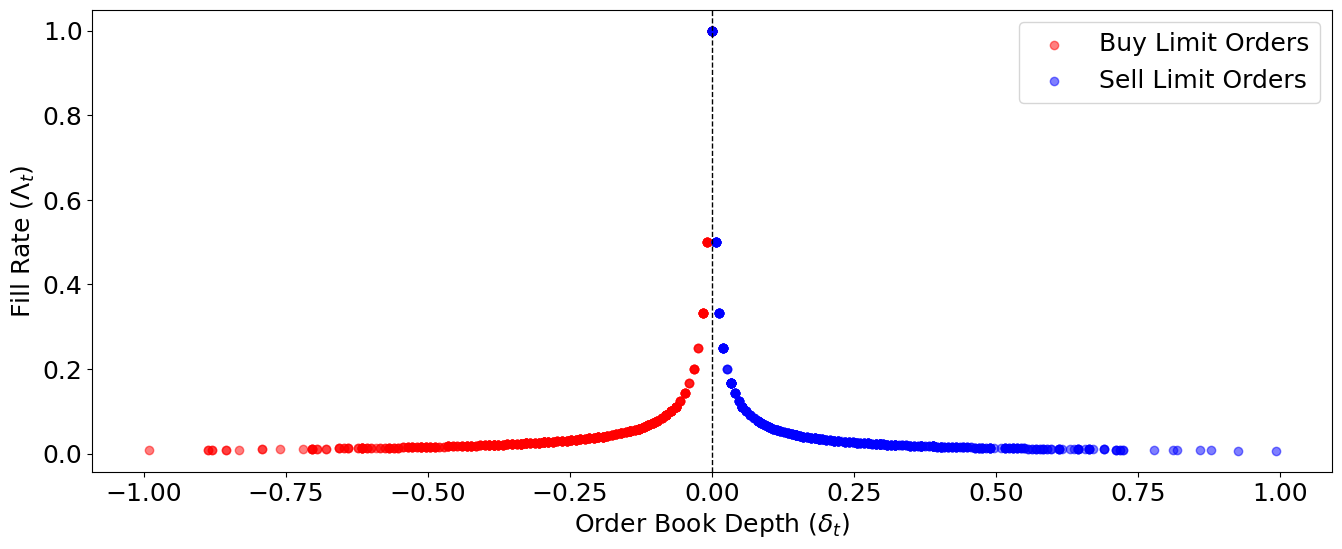

In [628]:
# Replace zero or negative depths with NaN to avoid divide-by-zero errors
merged_df.loc[merged_df['BuyDepth'] <= 0, 'BuyDepth'] = None
merged_df.loc[merged_df['SellDepth'] <= 0, 'SellDepth'] = None

# Compute Fill Rates
merged_df['FillRate_Buy'] = merged_df['Quantity'] / merged_df['BuyDepth']
merged_df['FillRate_Sell'] = merged_df['Quantity'] / merged_df['SellDepth']

# Fill NaN values (if depth was 0, assume no liquidity to fill)
merged_df[['FillRate_Buy', 'FillRate_Sell']] = merged_df[['FillRate_Buy', 'FillRate_Sell']].fillna(0)

# Compute Fill Rates
#merged_df['FillRate_Buy'] = merged_df['Quantity'] / merged_df['BuyDepth']
#merged_df['FillRate_Sell'] = merged_df['Quantity'] / merged_df['SellDepth']

# Fill NaN values (if depth was 0, assume no liquidity was filled)
#merged_df[['FillRate_Buy', 'FillRate_Sell']] = merged_df[['FillRate_Buy', 'FillRate_Sell']].fillna(0)

# Ensure merged_df exists before proceeding
plt.figure(figsize=(16, 5))
if 'merged_df' in locals() or 'merged_df' in globals():
    plt.figure(figsize=(16, 6))

    # Filter out zero fill rates
    buy_fill_data = merged_df[merged_df['FillRate_Buy'] > 0].copy()
    sell_fill_data = merged_df[merged_df['FillRate_Sell'] > 0].copy()

    # FIX: Reverse Buy Depth Normalization so that smaller depths are closer to 0
    buy_fill_data['Normalized_BuyDepth'] = -1 * ((buy_fill_data['BuyDepth'] - buy_fill_data['BuyDepth'].min())/ buy_fill_data['BuyDepth'].max())

    # Sell Depth remains the same (0 to 1)
    sell_fill_data['Normalized_SellDepth'] = ((sell_fill_data['SellDepth'] - sell_fill_data['SellDepth'].min()) / sell_fill_data['SellDepth'].max() )

    # Scatter plot of Normalized Fill Rate vs Depth
    plt.scatter(buy_fill_data['Normalized_BuyDepth'], buy_fill_data['FillRate_Buy'], color='red', alpha=0.5, label='Buy Limit Orders')
    plt.scatter(sell_fill_data['Normalized_SellDepth'], sell_fill_data['FillRate_Sell'], color='blue', alpha=0.5, label='Sell Limit Orders')

    # Labels and Title
    plt.xlabel("Order Book Depth ($\delta _t$)")
    plt.ylabel("Fill Rate ($\Lambda_t$)")
    #plt.title("Fill Rate vs Normalized Depth (Buy: 0 to -1, Sell: 0 to 1)")
    plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)  # Midpoint (spread)
    plt.legend()

    # Show plot
    plt.show()
else:
    print("Error: merged_df is not defined. Please reload your data and recompute the fill rates.")


In [629]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the exponential decay function
def exponential_decay(delta, lambda_, kappa):
    return lambda_ * np.exp(-kappa * delta)


In [630]:
# Filter valid fill rate data (exclude zeros)
buy_fill_data = merged_df[merged_df['FillRate_Buy'] > 0].copy()
sell_fill_data = merged_df[merged_df['FillRate_Sell'] > 0].copy()

# Normalize Depth: Scale Buy Depth to [-1, 0] and Sell Depth to [0, 1]
buy_fill_data['Normalized_BuyDepth'] = -1 * ((buy_fill_data['BuyDepth'] - buy_fill_data['BuyDepth'].min())/ buy_fill_data['BuyDepth'].max())
sell_fill_data['Normalized_SellDepth'] = ((sell_fill_data['SellDepth'] - sell_fill_data['SellDepth'].min()) / sell_fill_data['SellDepth'].max() )

buy_fill_data['Normalized_FillRate_Buy'] = -1 * ((buy_fill_data['BuyDepth'] - buy_fill_data['BuyDepth'].min())/ buy_fill_data['BuyDepth'].max())
sell_fill_data['Normalized_FillRate_Sell'] = ((sell_fill_data['SellDepth'] - sell_fill_data['SellDepth'].min()) / sell_fill_data['SellDepth'].max() )

# Fit exponential decay model for buy orders
popt_buy, _ = curve_fit(exponential_decay, buy_fill_data['Normalized_BuyDepth'], buy_fill_data['FillRate_Buy'], p0=[1, 1])
lambda_minus, kappa_minus = popt_buy  # Extract fitted parameters

# Fit exponential decay model for sell orders
popt_sell, _ = curve_fit(exponential_decay, sell_fill_data['Normalized_SellDepth'], sell_fill_data['FillRate_Sell'], p0=[1, 1])
lambda_plus, kappa_plus = popt_sell  # Extract fitted parameters

# Display the estimated parameters
print(f"Estimated Parameters:")
print(f"λ⁻ (Buy Side): {lambda_minus:.3f}, κ⁻ (Buy Side Decay Rate): {kappa_minus:.3f}")
print(f"λ⁺ (Sell Side): {lambda_plus:.3f}, κ⁺ (Sell Side Decay Rate): {kappa_plus:.3f}")


Estimated Parameters:
λ⁻ (Buy Side): 0.938, κ⁻ (Buy Side Decay Rate): -50.621
λ⁺ (Sell Side): 0.914, κ⁺ (Sell Side Decay Rate): 58.763


Estimated Parameters for Buy Side:
λ1⁻: 0.156, κ1⁻: -6.441, λ2⁻: 0.838, κ2⁻: -96.434
Estimated Parameters for Sell Side:
λ1⁺: 0.809, κ1⁺: 121.123, λ2⁺: 0.183, κ2⁺: 8.841


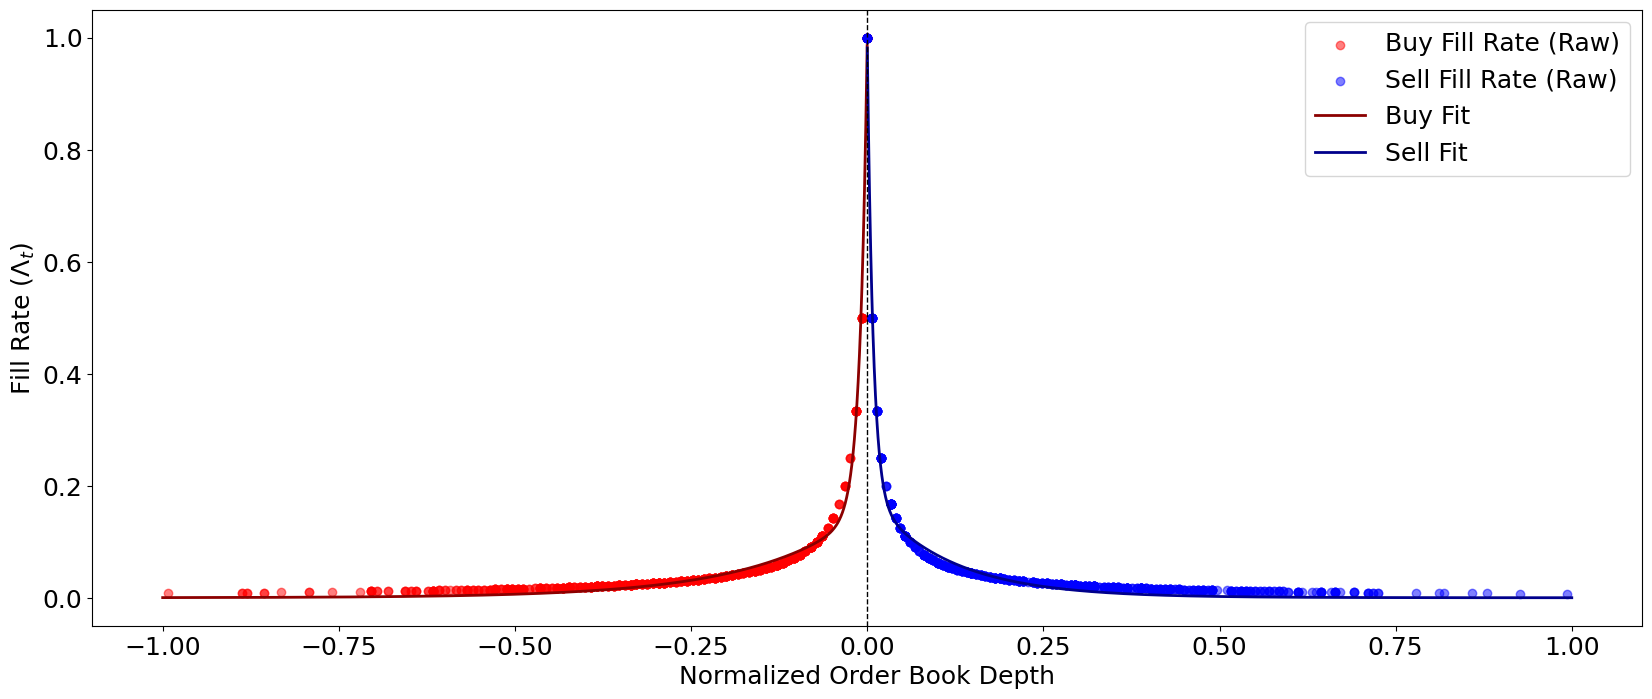

In [631]:
from scipy.optimize import curve_fit

# Normalize Fill Rates to be between 0 and 1
buy_fill_data['Normalized_FillRate_Buy'] = buy_fill_data['FillRate_Buy'] #/ buy_fill_data['FillRate_Buy'].max()
sell_fill_data['Normalized_FillRate_Sell'] = sell_fill_data['FillRate_Sell'] #/ sell_fill_data['FillRate_Sell'].max()

# Define the double exponential decay function
def double_exponential_decay(delta, lambda1, kappa1, lambda2, kappa2):
    return lambda1 * np.exp(-kappa1 * delta) + lambda2 * np.exp(-kappa2 * delta)

# Initial guesses for the parameters
initial_guess = [1, 1, 0.5, 0.5]

# Fit double exponential decay model for buy orders
popt_buy, _ = curve_fit(double_exponential_decay, buy_fill_data['Normalized_BuyDepth'], buy_fill_data['Normalized_FillRate_Buy'], p0=initial_guess)
lambda1_minus, kappa1_minus, lambda2_minus, kappa2_minus = popt_buy  # Extract fitted parameters

# Fit double exponential decay model for sell orders
popt_sell, _ = curve_fit(double_exponential_decay, sell_fill_data['Normalized_SellDepth'], sell_fill_data['Normalized_FillRate_Sell'], p0=initial_guess)
lambda1_plus, kappa1_plus, lambda2_plus, kappa2_plus = popt_sell  # Extract fitted parameters

# Display the estimated parameters
print(f"Estimated Parameters for Buy Side:")
print(f"λ1⁻: {lambda1_minus:.3f}, κ1⁻: {kappa1_minus:.3f}, λ2⁻: {lambda2_minus:.3f}, κ2⁻: {kappa2_minus:.3f}")
print(f"Estimated Parameters for Sell Side:")
print(f"λ1⁺: {lambda1_plus:.3f}, κ1⁺: {kappa1_plus:.3f}, λ2⁺: {lambda2_plus:.3f}, κ2⁺: {kappa2_plus:.3f}")

# Generate smooth x-axis points for fitted curves
depth_range = np.linspace(-1, 1, 10000)
plt.figure(figsize=(20, 8))

# Compute fitted curves
fit_buy = double_exponential_decay(depth_range[depth_range < 0], lambda1_minus, kappa1_minus, lambda2_minus, kappa2_minus)
fit_sell = double_exponential_decay(depth_range[depth_range >= 0], lambda1_plus, kappa1_plus, lambda2_plus, kappa2_plus)

# Plot scatter points (raw data)
plt.scatter(buy_fill_data['Normalized_BuyDepth'], buy_fill_data['Normalized_FillRate_Buy'], color='red', alpha=0.5, label='Buy Fill Rate (Raw)')
plt.scatter(sell_fill_data['Normalized_SellDepth'], sell_fill_data['Normalized_FillRate_Sell'], color='blue', alpha=0.5, label='Sell Fill Rate (Raw)')

# Plot fitted curves
plt.plot(depth_range[depth_range < 0], fit_buy, color='darkred', linestyle='-', linewidth=2, label='Buy Fit')
plt.plot(depth_range[depth_range >= 0], fit_sell, color='darkblue', linestyle='-', linewidth=2, label='Sell Fit')

# Labels and Title
plt.xlabel("Normalized Order Book Depth")
plt.ylabel("Fill Rate ($\Lambda_t$)")
plt.axvline(x=0, color='black', linestyle='dashed', linewidth=1)  # Spread boundary
plt.legend()

# Show plot
plt.show()


In [632]:
expanded_df.head(5)


Time  Bid Total Quantity       Bid Prices Bid Quantities  \
0  0.000                   0                              []   
1  0.112                   1                5            [1]   
2  0.149                   2           5, 137         [1, 1]   
3  0.261                   3      5, 137, 138      [1, 1, 1]   
4  0.299                   4  5, 42, 137, 138   [1, 1, 1, 1]   

   Ask Total Quantity Ask Prices Ask Quantities  Bid Depth  Ask Depth  \
0                   0                        []          0          0   
1                   0                        []          1          0   
2                   0                        []          2          0   
3                   0                        []          3          0   
4                   0                        []          4          0   

   Depth Difference    ParsedBidPrices ParsedAskPrices  HighestBid  LowestAsk  \
0                 0                 []              []         NaN        NaN   
1                 1                [5]              []         5.0        NaN   
2                 2           [5, 137]              []       137.0        NaN   
3                 3      [5, 137, 138]              []       138.0        NaN   
4                 4  [5, 42, 137, 138]              []       138.0        NaN   

   MidPrice  BuyDepth  SellDepth  
0       NaN       NaN        NaN  
1       NaN     250.0        NaN  
2       NaN     111.0        NaN  
3       NaN     129.0        NaN  
4       NaN     113.0        NaN

In [633]:
# Create bins of 1 second
bins = np.arange(0, expanded_df['Time'].max() + 1, 1)
labels = bins[:-1]

# Bin the Time column
expanded_df['Time_Binned'] = pd.cut(expanded_df['Time'], bins=bins, labels=labels, right=False)

# Display the resulting DataFrame with the new binned Time column
expanded_df.head(5)

Time  Bid Total Quantity       Bid Prices Bid Quantities  \
0  0.000                   0                              []   
1  0.112                   1                5            [1]   
2  0.149                   2           5, 137         [1, 1]   
3  0.261                   3      5, 137, 138      [1, 1, 1]   
4  0.299                   4  5, 42, 137, 138   [1, 1, 1, 1]   

   Ask Total Quantity Ask Prices Ask Quantities  Bid Depth  Ask Depth  \
0                   0                        []          0          0   
1                   0                        []          1          0   
2                   0                        []          2          0   
3                   0                        []          3          0   
4                   0                        []          4          0   

   Depth Difference    ParsedBidPrices ParsedAskPrices  HighestBid  LowestAsk  \
0                 0                 []              []         NaN        NaN   
1                 1                [5]              []         5.0        NaN   
2                 2           [5, 137]              []       137.0        NaN   
3                 3      [5, 137, 138]              []       138.0        NaN   
4                 4  [5, 42, 137, 138]              []       138.0        NaN   

   MidPrice  BuyDepth  SellDepth Time_Binned  
0       NaN       NaN        NaN         0.0  
1       NaN     250.0        NaN         0.0  
2       NaN     111.0        NaN         0.0  
3       NaN     129.0        NaN         0.0  
4       NaN     113.0        NaN         0.0

In [634]:
# Create bins of 1 second
bins = np.arange(0, expanded_df['Time'].max() + 1, 1)
labels = bins[:-1]

# Bin the Time column
expanded_df['Time_Binned'] = pd.cut(expanded_df['Time'], bins=bins, labels=labels, right=False)

# Group by the binned time and sum the bid total quantities
binned_bid_quantities = expanded_df.groupby('Time_Binned')['Bid Total Quantity'].sum().reset_index()
binned_ask_quantities = expanded_df.groupby('Time_Binned')['Ask Total Quantity'].sum().reset_index()

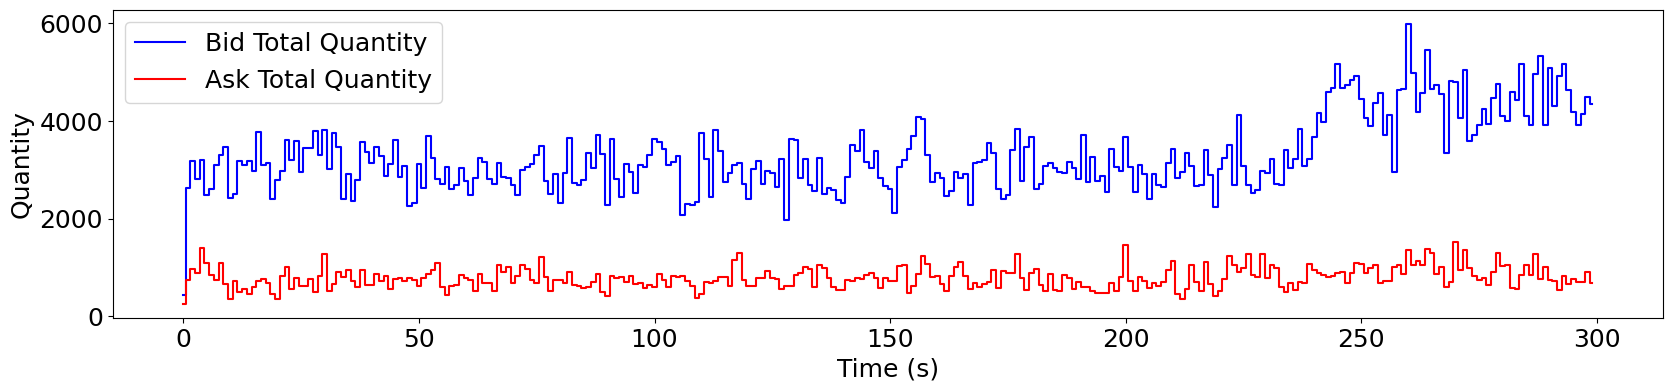

In [635]:
plt.figure(figsize=(20, 4))
plt.step(binned_bid_quantities['Time_Binned'], binned_bid_quantities['Bid Total Quantity'], where='mid', linestyle='-', color='blue', label = 'Bid Total Quantity')
plt.step(binned_ask_quantities['Time_Binned'], binned_ask_quantities['Ask Total Quantity'], where='mid', linestyle='-', color='red', label = 'Ask Total Quantity')
plt.xlabel('Time (s)')
plt.ylabel('Quantity')
plt.legend()
plt.grid(False)
plt.show()